In [1]:
!pip install allennlp

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import random
import time
import datetime
import json
import pandas as pd
import numpy as np
import torch
import pickle
from pathlib import Path
from torch.utils.data import DataLoader, Dataset
from transformers import BertForSequenceClassification, BertTokenizer, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup
import torch
from torch import nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from sklearn.metrics import f1_score
import copy

In [4]:
from steps import training_step, validation_step, testing_step

In [5]:
# Load the config file
def load_config(config_path):
    # Load and parse the config file
    with open(config_path, 'r') as f:
        config = json.load(f)

    return config

config = load_config('./HBiLSTM_CL.json')

In [6]:
from data import SequenceClassificationDataset

In [7]:
root = '/content/'
cl_train_dataset = SequenceClassificationDataset(Path(root, 'train_scibert.json'))
cl_dev_dataset = SequenceClassificationDataset(Path(root, 'dev_scibert.json'))
cl_test_dataset = SequenceClassificationDataset(Path(root, 'test_scibert.json'))

In [8]:
len(cl_train_dataset)

40

In [9]:
batch_size=1
train_dataloader = DataLoader(cl_train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(cl_dev_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(cl_test_dataset, batch_size=batch_size, shuffle=True)

In [10]:
from models import BertHSLN

In [11]:
BERT_MODEL = "bert-base-uncased"
mconfig = {
    "bert_model": BERT_MODEL,
    "bert_trainable": False,
    "model": BertHSLN.__name__,
    "cacheable_tasks": [],

    "dropout": 0.5,
    "word_lstm_hs": 384,
    "att_pooling_dim_ctx": 100,
    "att_pooling_num_ctx": 7,

    "lr": 3e-05,
    "lr_epoch_decay": 0.9,
    "batch_size":  32,
    "max_seq_length": 120,
    "max_epochs": 20,
    "early_stopping": 20,

}

In [12]:
torch.cuda.is_available()

True

In [13]:
# assign device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"device used: {device}")

device used: cuda


In [14]:
model = BertHSLN(mconfig, num_labels = 7)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Attention pooling dim: 5376


In [15]:
lr = mconfig['lr']#config['training']['learning_rate']

from torch.optim.lr_scheduler import StepLR
from torch.optim import Adam

optimizer = Adam(model.parameters(), lr=lr)
scheduler = StepLR(optimizer, step_size=1, gamma=mconfig["lr_epoch_decay"])


In [16]:

seed_val = config['training']['seed']
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [17]:
# assign device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"device used: {device}")
model.to(device)

device used: cuda


BertHSLN(
  (bert): BertTokenEmbedder(
    (bert): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0): BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_features=768, bias=True)
               

In [18]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

21328998

In [19]:
epochs = 20

In [20]:
train_epoch_losses = []
train_epoch_acc = []
train_epoch_f1 = []

dev_epoch_losses = []
dev_epoch_acc = []
dev_epoch_f1 = []


best_dev_f1 = 0
best_model = None


# Training loop
for epoch in range(epochs):
    print('======== Epoch {:} / {:} ========'.format(epoch + 1, epochs))

    # Training
    train_loss = training_step(model, optimizer, scheduler, train_dataloader, device)
    train_epoch_losses.append(train_loss)
    #train_epoch_acc.append(train_accuracy)
    #train_epoch_f1.append(train_f1)
    print(f"Epoch {epoch+1}/{epochs} - Training Loss: {train_loss:.4f}")

    # Validation
    dev_f1 = validation_step(model, valid_dataloader, device)
    #dev_epoch_losses.append(dev_loss)
    #dev_epoch_acc.append(dev_accuracy)
    dev_epoch_f1.append(dev_f1)
    print(f"Epoch {epoch+1}/{epochs} - F1 {dev_f1}")

    if dev_f1 > best_dev_f1:
        best_dev_f1 = dev_f1
        best_model = copy.deepcopy(model)

======== Epoch 1 / 20 ========


/content/steps.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  result[k] = torch.tensor(v)


Epoch 1/20 - Training Loss: 490.7767
1394 1394
Epoch 1/20 - F1 0.07690642317723494
======== Epoch 2 / 20 ========


/content/steps.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  result[k] = torch.tensor(v)


Epoch 2/20 - Training Loss: 452.8524
1394 1394
Epoch 2/20 - F1 0.14733743370616287
======== Epoch 3 / 20 ========


/content/steps.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  result[k] = torch.tensor(v)


Epoch 3/20 - Training Loss: 439.7441
1394 1394
Epoch 3/20 - F1 0.23763544344983595
======== Epoch 4 / 20 ========


/content/steps.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  result[k] = torch.tensor(v)


Epoch 4/20 - Training Loss: 415.7817
1394 1394
Epoch 4/20 - F1 0.23107328310938324
======== Epoch 5 / 20 ========


/content/steps.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  result[k] = torch.tensor(v)


Epoch 5/20 - Training Loss: 394.5577
1394 1394
Epoch 5/20 - F1 0.22504481568101603
======== Epoch 6 / 20 ========


/content/steps.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  result[k] = torch.tensor(v)


Epoch 6/20 - Training Loss: 384.1394
1394 1394
Epoch 6/20 - F1 0.30660042497102385
======== Epoch 7 / 20 ========


/content/steps.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  result[k] = torch.tensor(v)


Epoch 7/20 - Training Loss: 368.7627
1394 1394
Epoch 7/20 - F1 0.25303332883901547
======== Epoch 8 / 20 ========


/content/steps.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  result[k] = torch.tensor(v)


Epoch 8/20 - Training Loss: 361.7603
1394 1394
Epoch 8/20 - F1 0.30057780443508314
======== Epoch 9 / 20 ========


/content/steps.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  result[k] = torch.tensor(v)


Epoch 9/20 - Training Loss: 350.9746
1394 1394
Epoch 9/20 - F1 0.3493351082871634
======== Epoch 10 / 20 ========


/content/steps.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  result[k] = torch.tensor(v)


Epoch 10/20 - Training Loss: 344.0152
1394 1394
Epoch 10/20 - F1 0.3113256600428671
======== Epoch 11 / 20 ========


/content/steps.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  result[k] = torch.tensor(v)


Epoch 11/20 - Training Loss: 338.8134
1394 1394
Epoch 11/20 - F1 0.343349079513209
======== Epoch 12 / 20 ========


/content/steps.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  result[k] = torch.tensor(v)


Epoch 12/20 - Training Loss: 329.8848
1394 1394
Epoch 12/20 - F1 0.31345866519239435
======== Epoch 13 / 20 ========


/content/steps.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  result[k] = torch.tensor(v)


Epoch 13/20 - Training Loss: 325.8881
1394 1394
Epoch 13/20 - F1 0.3367168070123964
======== Epoch 14 / 20 ========


/content/steps.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  result[k] = torch.tensor(v)


Epoch 14/20 - Training Loss: 317.5133
1394 1394
Epoch 14/20 - F1 0.36161730741577325
======== Epoch 15 / 20 ========


/content/steps.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  result[k] = torch.tensor(v)


Epoch 15/20 - Training Loss: 313.4676
1394 1394
Epoch 15/20 - F1 0.3628165529221082
======== Epoch 16 / 20 ========


/content/steps.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  result[k] = torch.tensor(v)


Epoch 16/20 - Training Loss: 313.2233
1394 1394
Epoch 16/20 - F1 0.36382607776438886
======== Epoch 17 / 20 ========


/content/steps.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  result[k] = torch.tensor(v)


Epoch 17/20 - Training Loss: 307.7694
1394 1394
Epoch 17/20 - F1 0.36388464098372203
======== Epoch 18 / 20 ========


/content/steps.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  result[k] = torch.tensor(v)


Epoch 18/20 - Training Loss: 308.7303
1394 1394
Epoch 18/20 - F1 0.3762017454597986
======== Epoch 19 / 20 ========


/content/steps.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  result[k] = torch.tensor(v)


Epoch 19/20 - Training Loss: 304.0918
1394 1394
Epoch 19/20 - F1 0.3602448254809862
======== Epoch 20 / 20 ========


/content/steps.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  result[k] = torch.tensor(v)


Epoch 20/20 - Training Loss: 302.6491
1394 1394
Epoch 20/20 - F1 0.3562746753893513


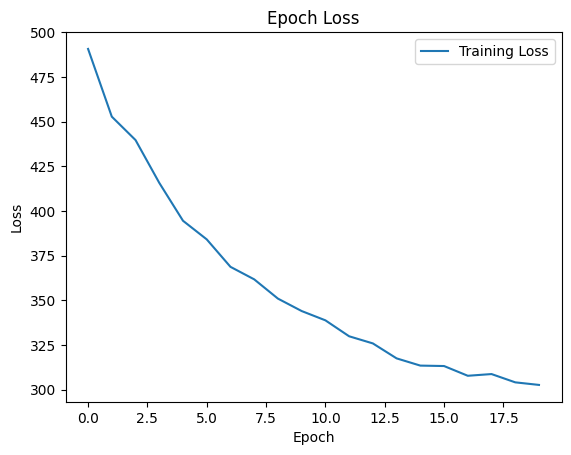

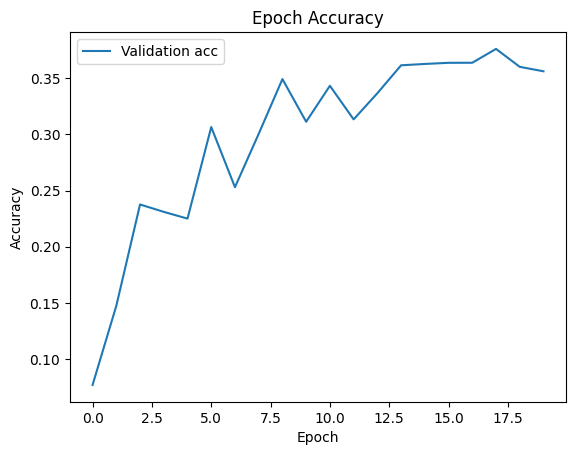

In [21]:
import matplotlib.pyplot as plt

# Plot the epoch loss
plt.plot(train_epoch_losses, label='Training Loss')
#plt.plot(dev_epoch_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Epoch Loss')
plt.show()

# Plot the epoch accuracies
#plt.plot(train_epoch_acc, label='Training acc')
plt.plot(dev_epoch_f1, label='Validation acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Epoch Accuracy')
plt.show()

In [22]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

device

device(type='cuda')

In [23]:
# Testing loop
test_loss, test_accuracy, predictions, true_labels = testing_step(model, test_dataloader, device)

/content/steps.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  result[k] = torch.tensor(v)


Testing Loss: 0.0000 - Testing Accuracy: 171.8000
              precision    recall  f1-score   support

           0       0.64      0.52      0.57       326
           1       0.93      0.77      0.84       201
           2       0.80      0.27      0.40       256
           3       0.55      0.95      0.70       434
           4       0.00      0.00      0.00        23
           5       0.75      0.25      0.38        12
           6       0.78      0.58      0.67        86

    accuracy                           0.64      1338
   macro avg       0.64      0.48      0.51      1338
weighted avg       0.68      0.64      0.62      1338



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [24]:
# Testing loop
test_loss, test_accuracy, predictions, true_labels = testing_step(best_model, test_dataloader, device)

/content/steps.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  result[k] = torch.tensor(v)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:772: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  ../aten/src/ATen/native/cudnn/RNN.cpp:968.)
  result = _VF.lstm(input, batch_sizes, hx, self._flat_weights, self.bias,


Testing Loss: 0.0000 - Testing Accuracy: 173.0000
              precision    recall  f1-score   support

           0       0.62      0.54      0.58       326
           1       0.92      0.76      0.83       201
           2       0.83      0.27      0.41       256
           3       0.56      0.95      0.70       434
           4       0.00      0.00      0.00        23
           5       0.75      0.25      0.38        12
           6       0.81      0.58      0.68        86

    accuracy                           0.65      1338
   macro avg       0.64      0.48      0.51      1338
weighted avg       0.69      0.65      0.62      1338



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [25]:
from steps import batch_to_tensor

In [90]:
model_path = '/content/drive/MyDrive/OS/BiLSTMCRF_checkpoint.pth'

In [91]:
def save_checkpoint(model, path):
  torch.save(model.state_dict(), path)

In [92]:
save_checkpoint(best_model, model_path)

In [57]:
from models import BertHSLN
def load_checkpoint(path, mconfig):
  model = BertHSLN(mconfig, num_labels = 7)
  model.load_state_dict(torch.load(path))
  model.to(device)
  return model

In [58]:
model = load_checkpoint(model_path, mconfig)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Attention pooling dim: 5376


In [59]:
outputs = []  # Initialize an empty list to store the iteration outputs
labels = []

In [60]:
model.eval()
for batch in train_dataloader:
   with torch.no_grad():
      batch = batch_to_tensor(batch)
      for key, tensor in batch.items():
          batch[key] = tensor.to(device)
      label = batch['label_ids']

      # Forward pass
      _,output = model(batch, label, get_embeddings = True)
      outputs.append(output)
      labels.append(label)

/content/steps.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  result[k] = torch.tensor(v)


In [61]:
labels = torch.cat(labels, dim=1)

In [62]:
result = torch.cat(outputs, dim=1)

In [63]:
result.shape, result.get_device()

(torch.Size([1, 10540, 768]), 0)

In [64]:
labels.shape, labels.get_device()

(torch.Size([1, 10540]), 0)

In [65]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [66]:
import numpy as np

def save_npy(t, path):
  # Move the tensor from GPU to CPU
  result_cpu_tensor = t.cpu()

  # Convert the CPU tensor to a NumPy array
  result_numpy_array = result_cpu_tensor.numpy()

  # Save the NumPy array to an NPY file
  np.save(path, result_numpy_array)

In [67]:
save_npy(result, '/content/drive/MyDrive/OS/data_store_keys_malik_CL.npy')

In [68]:
save_npy(labels, '/content/drive/MyDrive/OS/data_store_values_malik_CL.npy')

In [69]:
link_ratio = 0.7
link_temperature = 1.0
num_labels= 7

In [75]:
def get_logits(output, datastore_keys, datastore_values, link_ratio):
  sub_output, embeddings = output
  logits = sub_output['logits']

  # cosine similarity
  knn_feats = datastore_keys.squeeze(0).transpose(0, 1) # [feature_size, token_num]
  embeddings = embeddings.view(-1, embeddings.shape[-1])  # [bsz*sent_len, feature_size]

  sim = torch.mm(embeddings, knn_feats) # [bsz*sent_len, token_num]

  sent_len = embeddings.shape[0]
  token_num = 10540

  norm_1 = (knn_feats ** 2).sum(dim=0, keepdim=True).sqrt() # [1, token_num]
  norm_2 = (embeddings ** 2).sum(dim=1, keepdim=True).sqrt() # [bsz*sent_len, 1]
  scores = (sim / (norm_1 + 1e-10) / (norm_2 + 1e-10)).view(1, sent_len, -1) # [bsz, sent_len, token_num]
  knn_labels = datastore_values.view(1, 1, token_num).expand(1, sent_len, token_num) # [bsz, sent_len, token_num]

  topk_scores, topk_idxs = torch.topk(scores, dim=-1, k=5)  # [bsz, sent_len, topk]
  scores = topk_scores
  knn_labels = knn_labels.gather(dim=-1, index=topk_idxs)  # [bsz, sent_len, topk]

  sim_probs = torch.softmax(scores / link_temperature, dim=-1) # [bsz, sent_len, token_num]

  knn_probabilities = torch.zeros_like(sim_probs[:, :, 0]).unsqueeze(-1).repeat([1, 1, num_labels])  # [bsz, sent_len, num_labels]
  knn_probabilities = knn_probabilities.scatter_add(dim=2, index=knn_labels, src=sim_probs) # [bsz, sent_len, num_labels]

  probabilities = link_ratio*logits + (1-link_ratio)*knn_probabilities

  argmax_labels = torch.argmax(probabilities, 2, keepdim=False)

  return argmax_labels

In [76]:
def get_knn_labels(model, device, dataloader, datastore_keys, datastore_values, link_ratio):
  knn_labels = []
  test_ground_truth = []
  model.eval()
  for batch in dataloader:
    with torch.no_grad():
        batch = batch_to_tensor(batch)
        for key, tensor in batch.items():
            batch[key] = tensor.to(device)
        label = batch['label_ids']

        # Forward pass
        output = model(batch, get_embeddings = True)
        knn_label = get_logits(output, datastore_keys, datastore_values ,link_ratio)
        knn_labels.append(knn_label)
        test_ground_truth.append(label)
  return torch.cat(knn_labels, dim=1), torch.cat(test_ground_truth, dim=1)

In [72]:
datastore_keys = np.load('/content/drive/MyDrive/OS/data_store_keys_malik_CL.npy')
datastore_values = np.load('/content/drive/MyDrive/OS/data_store_values_malik_CL.npy')

In [73]:
datastore_keys = torch.from_numpy(datastore_keys).to(torch.device("cuda"))
datastore_values = torch.from_numpy(datastore_values).to(torch.device("cuda"))

In [81]:
knn_labels, test_ground_truth = get_knn_labels(model, device, test_dataloader, datastore_keys, datastore_values, 1.0)
predictions = knn_labels.squeeze(0).cpu().numpy()
true_labels = test_ground_truth.squeeze(0).cpu().numpy()
weighted_f1 = f1_score(true_labels, predictions, average='weighted')
print(weighted_f1)

/content/steps.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  result[k] = torch.tensor(v)


0.6242920108971577


In [82]:
f1s = {}

start = 0.0
end = 1.0
step = 0.1

for link_ratio in np.arange(start, end + step, step):
  print(link_ratio)
  knn_labels, test_ground_truth = get_knn_labels(model, device, test_dataloader, datastore_keys, datastore_values, link_ratio)
  predictions = knn_labels.squeeze(0).cpu().numpy()
  true_labels = test_ground_truth.squeeze(0).cpu().numpy()
  f1 = f1_score(true_labels, predictions, average='weighted')
  f1s[link_ratio] = f1

0.0


/content/steps.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  result[k] = torch.tensor(v)


0.1


/content/steps.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  result[k] = torch.tensor(v)


0.2


/content/steps.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  result[k] = torch.tensor(v)


0.30000000000000004


/content/steps.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  result[k] = torch.tensor(v)


0.4


/content/steps.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  result[k] = torch.tensor(v)


0.5


/content/steps.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  result[k] = torch.tensor(v)


0.6000000000000001


/content/steps.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  result[k] = torch.tensor(v)


0.7000000000000001


/content/steps.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  result[k] = torch.tensor(v)


0.8


/content/steps.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  result[k] = torch.tensor(v)


0.9


/content/steps.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  result[k] = torch.tensor(v)


1.0


/content/steps.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  result[k] = torch.tensor(v)


In [83]:
f1s

{0.0: 0.48741970917844774,
 0.1: 0.512860056086285,
 0.2: 0.5537372851515516,
 0.30000000000000004: 0.575817744687894,
 0.4: 0.6002831851943864,
 0.5: 0.6149046165439612,
 0.6000000000000001: 0.6214636731510789,
 0.7000000000000001: 0.6309207348073347,
 0.8: 0.6286688969470816,
 0.9: 0.6275323749995336,
 1.0: 0.6242920108971577}

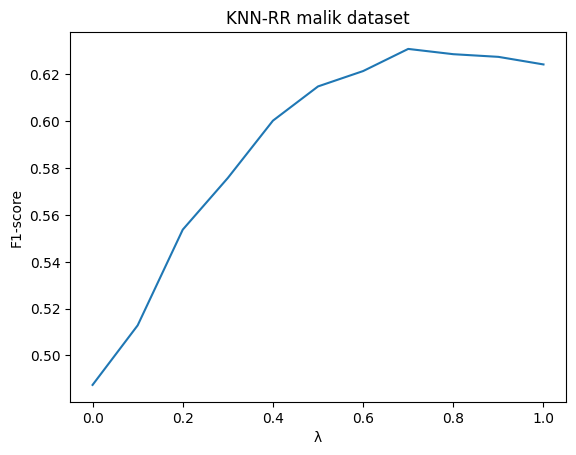

In [89]:
x = list(f1s.keys())
y = list(f1s.values())

plt.plot(x, y)
plt.xlabel('λ')
plt.ylabel('F1-score')
plt.title('KNN-RR malik dataset')
plt.show()

In [54]:
knn_labels, test_ground_truth = get_knn_labels(model, device, test_dataloader, datastore_keys, datastore_values)

In [55]:
# Convert tensors to numpy arrays
predictions = knn_labels.squeeze(0).cpu().numpy()
true_labels = test_ground_truth.squeeze(0).cpu().numpy()

In [56]:
from sklearn.metrics import classification_report

print(classification_report(true_labels, predictions))

              precision    recall  f1-score   support

           0       0.62      0.53      0.58       326
           1       0.84      0.79      0.81       201
           2       0.83      0.36      0.50       256
           3       0.57      0.91      0.71       434
           4       0.00      0.00      0.00        23
           5       0.50      0.08      0.14        12
           6       0.75      0.60      0.67        86

    accuracy                           0.65      1338
   macro avg       0.59      0.47      0.49      1338
weighted avg       0.68      0.65      0.63      1338



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [141]:
sub_output, embeddings = output
logits = sub_output['logits']

In [142]:
embeddings.shape, logits.shape

(torch.Size([1, 17, 768]), torch.Size([1, 17, 7]))

In [143]:
result.shape

torch.Size([1, 10540, 768])

In [144]:
#feature_size = 768

# cosine similarity
knn_feats = result.squeeze(0).transpose(0, 1) # [feature_size, token_num]
embeddings = embeddings.view(-1, embeddings.shape[-1])  # [bsz*sent_len, feature_size]


In [145]:
knn_feats.shape, embeddings.shape

(torch.Size([768, 10540]), torch.Size([17, 768]))

In [146]:

sim = torch.mm(embeddings, knn_feats) # [bsz*sent_len, token_num]


In [147]:
sim.shape

torch.Size([17, 10540])

In [151]:
sent_len = embeddings.shape[0]
token_num = 10540

In [152]:
sent_len

17

In [153]:
norm_1 = (knn_feats ** 2).sum(dim=0, keepdim=True).sqrt() # [1, token_num]
norm_2 = (embeddings ** 2).sum(dim=1, keepdim=True).sqrt() # [bsz*sent_len, 1]
scores = (sim / (norm_1 + 1e-10) / (norm_2 + 1e-10)).view(1, sent_len, -1) # [bsz, sent_len, token_num]

In [154]:
scores.shape

torch.Size([1, 17, 10540])

In [155]:
knn_labels = labels.view(1, 1, token_num).expand(1, sent_len, token_num) # [bsz, sent_len, token_num]


In [156]:
topk_scores, topk_idxs = torch.topk(scores, dim=-1, k=5)  # [bsz, sent_len, topk]
scores = topk_scores
knn_labels = knn_labels.gather(dim=-1, index=topk_idxs)  # [bsz, sent_len, topk]


In [157]:
link_temperature = 0.7

In [158]:
sim_probs = torch.softmax(scores / link_temperature, dim=-1) # [bsz, sent_len, token_num]

In [159]:
num_labels = 7

In [160]:
knn_probabilities = torch.zeros_like(sim_probs[:, :, 0]).unsqueeze(-1).repeat([1, 1, num_labels])  # [bsz, sent_len, num_labels]
knn_probabilities = knn_probabilities.scatter_add(dim=2, index=knn_labels, src=sim_probs) # [bsz, sent_len, num_labels]


In [162]:
knn_probabilities.shape, logits.shape

(torch.Size([1, 17, 7]), torch.Size([1, 17, 7]))

In [166]:
probabilities = link_ratio*logits + (1-link_ratio)*knn_probabilities
probabilities.shape

torch.Size([1, 17, 7])

In [167]:
argmax_labels = torch.argmax(probabilities, 2, keepdim=False)

In [169]:
argmax_labels.shape

torch.Size([1, 17])